In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
pd.set_option('display.max_rows', None)        # Show all rows
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.width', None)           # Disable line wrapping
pd.set_option('display.max_colwidth', None)    # Show full column content (especially for strings)

def load_and_sort_csv(path):
    df = pd.read_csv(path, parse_dates=['date'], index_col='date')
    df.index = df.index.strftime('%Y-%m-%d')
    return df.sort_index(ascending=True)
path = '../data/final/final_dataset.csv'

In [7]:
df = load_and_sort_csv(path)

df['Oil_Crude_Price'] = df['Oil_Crude_Price'].clip(lower=0)

X = df.drop(columns=['btc_price'], axis=1)
y = df['btc_price']

## Handling Missing data

In [8]:
# --- 2. Handle Missing Values (NaNs) ---
print(f"\nMissing values before handling:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
df.ffill(inplace=True)
df.bfill(inplace=True)
print(f"\nMissing values after ffill and bfill:\n{df.isnull().sum().sum()}")


Missing values before handling:
Series([], dtype: int64)

Missing values after ffill and bfill:
0


## Trends, Seasonality, Skewness, Heteroscedasticity

In [ ]:
# # 2. Plot the raw time series
# plt.figure()
# y.plot(title='Bitcoin Close Price')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.show()

# # 3. Decompose time series into trend, seasonality, and residuals
# decomp = seasonal_decompose(y, model='multiplicative', period=365)
# decomp.plot()
# plt.suptitle('Seasonal Decompose (Multiplicative)', y=1.02)
# plt.show()

# # 4. Skewness calculation and distribution histogram
# skewness = y.skew()
# print(f"Skewness of Close Price: {skewness:.4f}")

# plt.figure()
# y.hist(bins=50)
# plt.title('Distribution of Bitcoin Close Price')
# plt.xlabel('Close Price')
# plt.ylabel('Frequency')
# plt.show()

# # 5. Heteroscedasticity: 30-day rolling variance plot
# rolling_var = y.rolling(window=30).var()
# plt.figure()
# rolling_var.plot(title='30-Day Rolling Variance of Close Price')
# plt.xlabel('Date')
# plt.ylabel('Variance')
# plt.show()

# # 6. ARCH test for heteroscedasticity
# arch_stat, arch_pvalue, _, _ = het_arch(y.dropna())
# print(f"ARCH Test — statistic: {arch_stat:.4f}, p-value: {arch_pvalue:.4f}")



- what technique applied to make the seasonal decomposition ideal when later fit into ML models
- skewness = 1.06 -> right-skewed (extreme vlaue happen less but still stretch tail to the right)

In [9]:
# Log return
y_log = np.log(y).diff()

# Standardize
y_log_reshape = y_log.values.reshape(-1, 1) # (n_samples, 1)

y_series = pd.Series(y_log_reshape.flatten(), index=df.index)

y_series = y_series.dropna()

In [ ]:
# def invert_log_return_prediction(y_hat, scaler: StandardScaler, y_prev: float):
#     """
#     Convert predicted standardized log returns back to actual prices.

#     Parameters:
#     - y_hat: array-like, predicted standardized log returns
#     - scaler: fitted StandardScaler used on original log returns
#     - y_prev: float, last known actual price before prediction starts

#     Returns:
#     - np.ndarray of predicted actual prices
#     """
#     # Step 1: Invert standardization (z -> log return)
#     log_returns = scaler.inverse_transform(np.array(y_hat).reshape(-1, 1)).flatten()

#     # Step 2: Recover log prices
#     log_y0 = np.log(y_prev)
#     log_prices = np.cumsum(np.insert(log_returns, 0, log_y0))

#     # Step 3: Convert log prices to actual prices
#     prices = np.exp(log_prices)

#     # Exclude the first value which corresponds to y_prev
#     return prices[1:]

# y_hat = [0.2, -0.1, 0.05]

# y_pred = invert_log_return_prediction(y_hat, scaler, y.iloc[0])

# y_pred

# check skewness

In [ ]:
# already_normalized_grp = ['PiCycle_cbbi', 'RUPL_cbbi', 'RHODL_cbbi', 'Puell_cbbi', '2YMA_cbbi',
#        'Trolololo_cbbi', 'MVRV_cbbi', 'ReserveRisk_cbbi', 'Woobull_cbbi',
#        'Confidence_cbbi']

In [11]:
X_copy = X.copy()

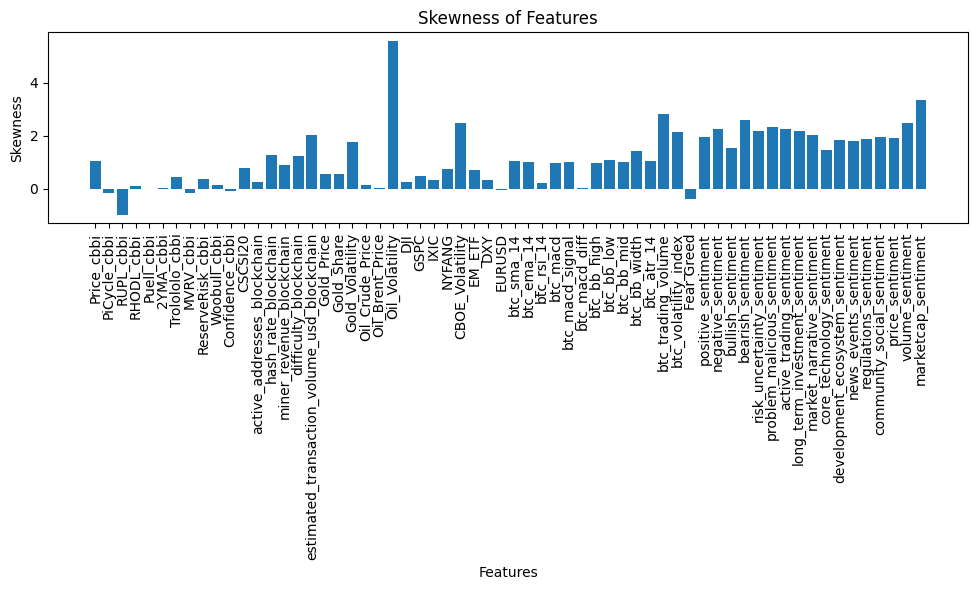

In [12]:
skew_values = [X_copy[col].skew() for col in X_copy.columns]
# # print skew value along with col name
# for col, skew in zip(X_copy.columns, skew_values):
#   print(f"Column: '{col}' - Skewness: {skew:.4f}")
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(X_copy.columns, skew_values)
plt.title('Skewness of Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [13]:
from sklearn.preprocessing import PowerTransformer

remain = [col for col in X_copy.columns if col]

for col in remain:
  current_skewness = X_copy[col].skew()
  print(f"Column: '{col}' - Original Skewness: {current_skewness:.4f}")

  if -0.5 <= current_skewness <= 0.5:
    continue
  else:
    # Log transform is generally for positive (right) skew
    if current_skewness > 0.5:
        # Check for negative values before applying log
        if (X_copy[col] < 0).any():
          print(f"  Action: Column '{col}' has negative value ({current_skewness:.4f}).")
          pt = PowerTransformer(method='yeo-johnson', standardize=False) # standardize=False if you do it later
          # Reshape column to be 2D for sklearn
          X_copy[col] = pt.fit_transform(X_copy[col].values.reshape(-1, 1))
          print(f"  New Skewness for '{col}': {X_copy[col].skew():.4f}\n")
        else:
            print(f"  Action: Applying np.log1p (log(1+x)) transformation due to positive skew > 0.5.")
            pt = PowerTransformer(method='box-cox', standardize=False) # standardize=False if you do it later
            # Reshape column to be 2D for sklearn
            X_copy[col] = pt.fit_transform(X_copy[col].values.reshape(-1, 1))
            print(f"  New Skewness for '{col}': {X_copy[col].skew():.4f}\n")
    elif current_skewness < -0.5:
        print(f"  Action: Column '{col}' is negatively skewed ({current_skewness:.4f}).")
        pt = PowerTransformer(method='yeo-johnson', standardize=False) # standardize=False if you do it later
        # Reshape column to be 2D for sklearn
        X_copy[col] = pt.fit_transform(X_copy[col].values.reshape(-1, 1))
        print(f"  New Skewness for '{col}': {X_copy[col].skew():.4f}\n")

print("Conditional log transformation process completed.")

Column: 'Price_cbbi' - Original Skewness: 1.0567
  Action: Applying np.log1p (log(1+x)) transformation due to positive skew > 0.5.
  New Skewness for 'Price_cbbi': -0.0541

Column: 'PiCycle_cbbi' - Original Skewness: -0.1574
Column: 'RUPL_cbbi' - Original Skewness: -0.9769
  Action: Column 'RUPL_cbbi' is negatively skewed (-0.9769).
  New Skewness for 'RUPL_cbbi': -0.1925

Column: 'RHODL_cbbi' - Original Skewness: 0.1167
Column: 'Puell_cbbi' - Original Skewness: -0.0215
Column: '2YMA_cbbi' - Original Skewness: 0.0383
Column: 'Trolololo_cbbi' - Original Skewness: 0.4580
Column: 'MVRV_cbbi' - Original Skewness: -0.1750
Column: 'ReserveRisk_cbbi' - Original Skewness: 0.3731
Column: 'Woobull_cbbi' - Original Skewness: 0.1573
Column: 'Confidence_cbbi' - Original Skewness: -0.0677
Column: 'CSCSI20' - Original Skewness: 0.8048
  Action: Applying np.log1p (log(1+x)) transformation due to positive skew > 0.5.
  New Skewness for 'CSCSI20': -0.1024

Column: 'active_addresses_blockchain' - Origina

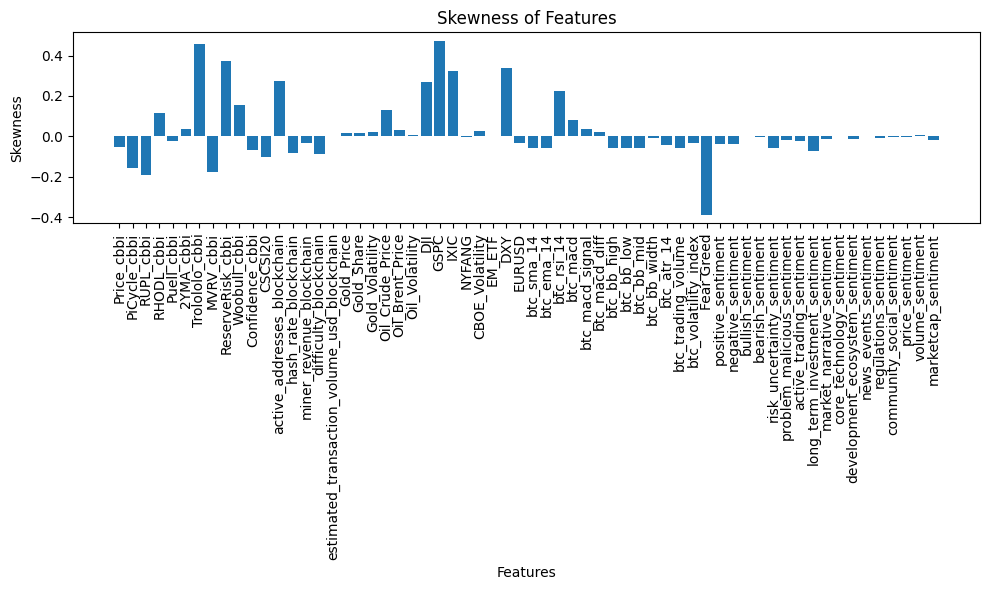

In [14]:
skew_values = [X_copy[col].skew() for col in X_copy.columns]
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(X_copy.columns, skew_values)
plt.title('Skewness of Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [15]:
# prompt: concat X_copy and y_series to form new df
y_series.name = 'btc_price'
# Concatenate X_copy and y_series
new_df = pd.concat([X_copy, y_series], axis=1)
new_df = new_df.dropna()

In [ ]:
# new_df.to_csv("/content/drive/MyDrive/Main Sharing 1/TMA/Data/processed_dataset.csv", index=True)

In [16]:
new_df.head()

,Price_cbbi,PiCycle_cbbi,RUPL_cbbi,RHODL_cbbi,Puell_cbbi,2YMA_cbbi,Trolololo_cbbi,MVRV_cbbi,ReserveRisk_cbbi,Woobull_cbbi,Confidence_cbbi,CSCSI20,active_addresses_blockchain,hash_rate_blockchain,miner_revenue_blockchain,difficulty_blockchain,estimated_transaction_volume_usd_blockchain,Gold_Price,Gold_Share,Gold_Volatility,Oil_Crude_Price,Oil_Brent_Price,Oil_Volatility,DJI,GSPC,IXIC,NYFANG,CBOE_Volatility,EM_ETF,DXY,EURUSD,btc_sma_14,btc_ema_14,btc_rsi_14,btc_macd,btc_macd_signal,btc_macd_diff,btc_bb_high,btc_bb_low,btc_bb_mid,btc_bb_width,btc_atr_14,btc_trading_volume,btc_volatility_index,Fear Greed,positive_sentiment,negative_sentiment,bullish_sentiment,bearish_sentiment,risk_uncertainty_sentiment,problem_malicious_sentiment,active_trading_sentiment,long_term_investment_sentiment,market_narrative_sentiment,core_technology_sentiment,development_ecosystem_sentiment,news_events_sentiment,regulations_sentiment,community_social_sentiment,price_sentiment,volume_sentiment,marketcap_sentiment,btc_price
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-02,13.536191,0.6518,2.733461,0.4958,0.5234,0.5285,0.0504,0.6869,0.3014,0.4577,0.5078,8.600460,565742.0,167.305364,259.431190,3856.355518,18.972277,3.118281,2.519816,1.219492,52.610001,55.080002,0.799029,21002.970703,2381.919922,5861.220215,8.003315,1.275533,0.743589,102.199997,1.053585,13.730531,13.787773,79.815674,55.633662,44.672866,11.771250,14.466056,12.931485,13.799305,4.195016,4.604483,9111.228854,4.814069,78.0,3.126792,3.567769,4.969426,3.798360,2.960416,3.254686,3.112208,3.048954,2.639122,4.930702,3.862016,4.494840,4.084705,3.875820,5.527814,3.671030,3.675855,0.023053
2017-03-03,13.618587,0.6532,2.772381,0.5027,0.5163,0.5361,0.0605,0.6834,0.3131,0.4651,0.5123,8.698953,583123.0,167.535727,258.475164,3867.055711,18.951905,3.117547,2.519676,1.216720,53.330002,55.900002,0.798778,21005.710938,2383.120117,5870.750000,8.003575,1.258592,0.743665,101.540001,1.050972,13.778611,13.837230,81.520321,59.937300,47.647432,13.232533,14.535609,12.939830,13.841288,4.277907,4.583769,8543.321346,4.132547,77.0,3.104306,3.529787,4.785199,3.798360,2.934249,3.190974,3.084455,3.039203,2.480807,4.899891,3.839821,4.498714,4.058886,3.707836,5.474116,3.405555,3.589215,0.018987
2017-03-06,13.675647,0.6581,2.770489,0.5017,0.4910,0.5394,0.0658,0.6837,0.3234,0.4696,0.5125,8.738074,537229.0,164.925624,255.464868,3900.677277,18.617946,3.117432,2.518086,1.211450,53.200001,56.009998,0.799718,20954.339844,2375.310059,5849.180176,8.001457,1.264400,0.743670,101.639999,1.062045,13.904685,13.938234,77.372747,63.025790,54.605089,8.901292,14.644408,13.076056,13.963128,4.217107,4.522592,6321.717402,2.803537,69.0,3.031744,3.448090,4.040869,3.323592,2.822831,3.092432,2.924229,2.981534,2.136655,4.858268,3.803837,4.275077,3.950363,3.580643,5.208206,3.226535,3.014174,-0.001696
2017-03-07,13.744595,0.6597,2.770489,0.5058,0.5037,0.5455,0.0740,0.6802,0.3249,0.4764,0.5167,8.620409,571329.0,168.099816,262.028082,3900.677277,18.773662,3.116345,2.516176,1.211192,53.139999,55.919998,0.799388,20924.759766,2368.389893,5833.930176,7.999727,1.268605,0.743681,101.809998,1.057921,13.926555,13.946988,64.307615,59.280409,55.454265,3.795740,14.643747,13.147078,13.995405,4.101852,4.641252,8259.795590,5.478830,65.0,3.084650,3.549675,4.409145,3.965869,2.897387,3.155599,3.044642,3.019316,2.327274,4.991588,3.862246,4.505138,4.073363,3.734964,5.309397,3.050781,2.967945,-0.039494
2017-03-08,13.655566,0.6610,2.698011,0.5103,0.4516,0.5357,0.0616,0.6943,0.3260,0.4660,0.5083,8.478927,526233.0,164.925624,249.758399,3900.677277,18.685647,3.115575,2.514699,1.215737,50.279999,53.110001,0.802302,20855.730469,2362.979980,5837.549805,7.999665,1.276468,0.743586,102.070000,1.057015,13.933112,13.926695,50.583481,50.376090,54.369765,-4.847333,14.626678,13.206159,14.013605,3.973481,4.784404,8731.239809,5.761718,65.0,3.071093,3.531829,4.144879,3.943983,2.915689,3.116130,3.014748,3.009411,2.376610,4.889656,3.839821,4.662056,4.278283,3.606432,5.